In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest


In [2]:
X = pd.read_csv('X_train_processed.csv')
y = pd.read_csv('y_train.csv')

In [3]:
X

,id,max_ECG_P_Offsets,max_ECG_P_Offsets_amplitudes,max_ECG_P_Onsets,max_ECG_P_Onsets_amplitudes,max_ECG_R_Offsets,max_ECG_R_Offsets_amplitudes,max_ECG_R_Onsets,max_ECG_R_Onsets_amplitudes,max_ECG_T_Offsets,...,mean_QRS_complexes,mean_RR_intervals,median_QRS_complexes,median_RR_intervals,min_QRS_complexes,min_RR_intervals,range_QRS_complexes,range_RR_intervals,std_QRS_complexes,std_RR_intervals
0,0,16063.0,0.094495,16029.0,0.192339,NaN,0.627930,16047.0,0.202995,16181.0,...,58.317460,244.753846,52.0,249.0,22.0,97.0,101.0,159.0,24.276728,19.614775
1,1,NaN,0.153579,NaN,0.197364,8623.0,0.314614,NaN,0.629199,8636.0,...,49.257143,236.714286,51.0,239.0,30.0,209.0,38.0,50.0,9.589705,13.183478
2,2,NaN,0.104904,NaN,0.080774,7982.0,0.651112,NaN,0.197722,NaN,...,54.428571,270.206897,54.0,272.0,52.0,252.0,6.0,46.0,1.178030,10.587499
3,3,NaN,0.421189,NaN,0.194120,NaN,0.240899,NaN,0.376299,NaN,...,51.333333,121.984615,56.0,115.0,42.0,101.0,14.0,102.0,6.599663,21.018301
4,4,NaN,0.236665,NaN,0.292782,NaN,0.636472,NaN,0.456670,NaN,...,45.023256,183.727273,50.0,180.0,29.0,153.0,35.0,132.0,10.601642,20.749988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5112,5112,NaN,0.188486,NaN,0.115610,NaN,0.650008,NaN,0.219436,NaN,...,42.100000,226.200000,40.0,250.5,27.0,102.0,39.0,441.0,11.449454,92.743517
5113,5113,NaN,0.054639,NaN,0.140889,8439.0,0.027929,NaN,0.283249,8453.0,...,52.166667,259.375000,50.5,259.0,35.0,252.0,44.0,22.0,11.328676,4.158951
5114,5114,NaN,0.073282,NaN,0.504250,7974.0,0.112013,NaN,0.695126,8051.0,...,49.000000,237.181818,54.0,237.0,29.0,200.0,32.0,99.0,10.201010,28.721710
5115,5115,8324.0,0.192861,8304.0,0.015025,NaN,0.265844,8342.0,0.198617,NaN,...,44.968750,254.500000,48.0,254.0,29.0,237.0,26.0,33.0,7.650508,8.403868


In [4]:
y

,id,y
0,0,0
1,1,0
2,2,0
3,3,1
4,4,2
...,...,...
5112,5112,3
5113,5113,0
5114,5114,0
5115,5115,0


In [5]:
X = X.set_index('id')
y = y.set_index('id')

In [6]:
drop_columns = [
    'HRV_MeanNN',
    'HRV_MedianNN',
    'HRV_LF',
    'HRV_LFHF',
    'HRV_LFn',
    'HRV_SDANN1',
    'HRV_SDANN2',
    'HRV_SDANN5',
    'HRV_SDNNI1',
    'HRV_SDNNI2',
    'HRV_SDNNI5',
    'HRV_ULF',
    'HRV_VLF',   
]

In [7]:
X = X.drop(columns=drop_columns)

In [8]:
kept_columns = ['median_RR_intervals',
 'HRV_CVSD',
 'mean_of_std_Heartbeats',
 'min_of_std_Heartbeats',
 'HRV_TINN',
 'median_P_amplitudes',
 'HRV_MCVNN',
 'min_RR_intervals',
 'HRV_pNN20',
 'HRV_pNN50',
 'HRV_HF',
 'std_R_amplitudes',
 'HRV_HFn',
 'HRV_VHF',
 'range_of_std_Heartbeats',
 'min_QRS_complexes',
 'HRV_CVNN',
 'mean_RR_intervals',
 'max_Q_amplitudes',
 'mean_R_amplitudes',
]

In [9]:
# split the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
# for cls in range(4):
#     X_cur = X_train[y['y'] == cls][kept_columns]
#     X_cur = X_cur.dropna()
#     ids = X_cur.index
#     clf = IsolationForest(random_state=0).fit(X_cur)
#     mask = clf.predict(X_cur)
#     pos = np.where(mask == -1)[0]
#     drop_ids = [ids[i] for i in pos]
#     X_train = X_train.drop(drop_ids)
#     y_train = y_train.drop(drop_ids)

In [11]:
# build the lightgbm model
d_train=lgbm.Dataset(X_train, label=y_train)

#setting up the parameters
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='multiclass' #Multi-class target feature
params['metric']='multi_logloss' #metric for multi-class
params['max_depth']=9
# params['num_leaves']=64
params['num_class']=4 #no.of unique values in the target class not inclusive of the end value

#training the model
clf=lgbm.train(params,d_train,100)  #training the model on 100 epocs

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46992
[LightGBM] [Info] Number of data points in the train set: 3581, number of used features: 201
[LightGBM] [Info] Start training from score -0.530377
[LightGBM] [Info] Start training from score -2.434004
[LightGBM] [Info] Start training from score -1.228759
[LightGBM] [Info] Start training from score -3.464898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [12]:
# predict the results
y_val_pred = clf.predict(X_val)
y_val_pred = [np.argmax(line) for line in y_val_pred]

In [13]:
# view accuracy
from sklearn.metrics import f1_score
accuracy = f1_score(y_val_pred, y_val, average='micro')
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy))

LightGBM Model accuracy score: 0.8066


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

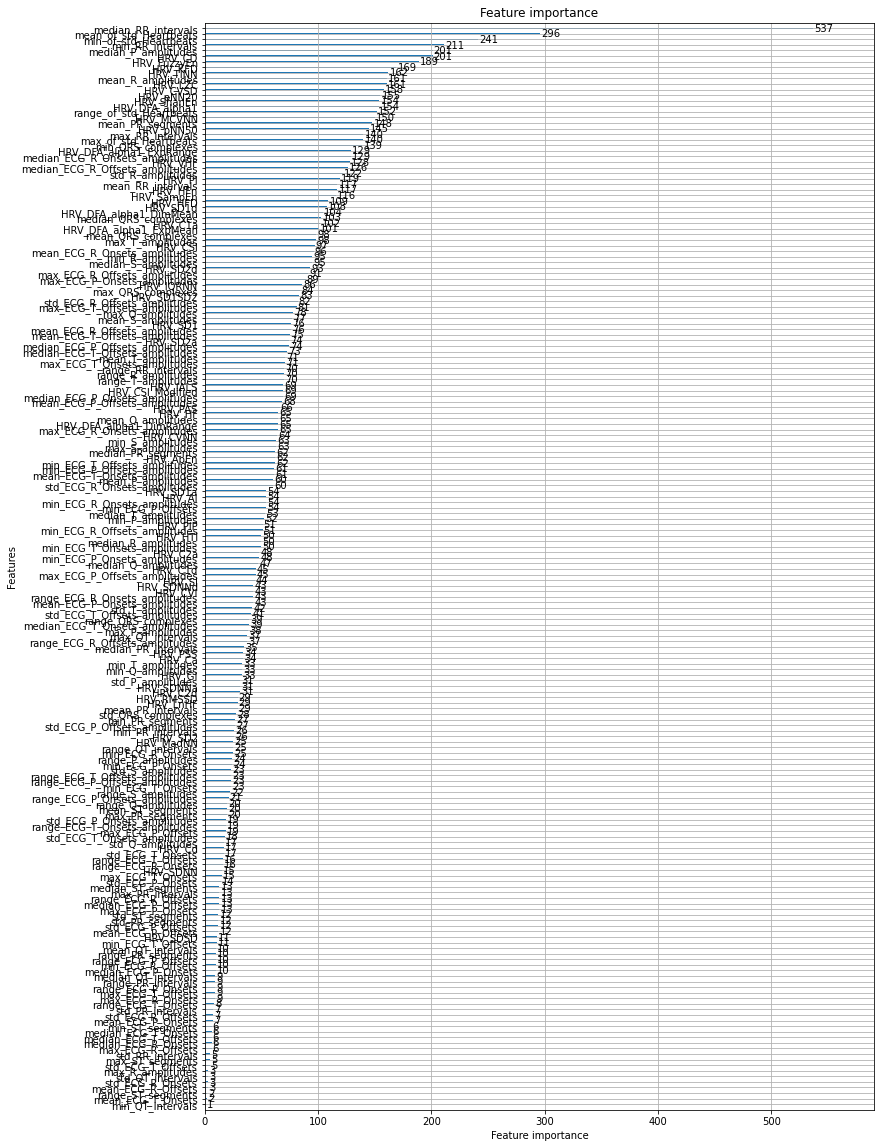

In [14]:
lgbm.plot_importance(clf, figsize=(12,20))

In [15]:
df_feature_importance = (
    pd.DataFrame({
        'feature': clf.feature_name(),
        'importance': clf.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)

In [16]:
df_feature_importance

,feature,importance
199,median_RR_intervals,537
191,mean_of_std_Heartbeats,296
192,min_of_std_Heartbeats,241
201,min_RR_intervals,211
78,HRV_CD,201
...,...,...
106,HRV_RCMSE,0
107,HRV_S,0
90,HRV_DFA_alpha2,0
79,HRV_CMSE,0


In [17]:
kept_columns = df_feature_importance['feature'].tolist()[:30]
kept_columns

['median_RR_intervals',
 'mean_of_std_Heartbeats',
 'min_of_std_Heartbeats',
 'min_RR_intervals',
 'HRV_CD',
 'median_P_amplitudes',
 'HRV_FuzzyEn',
 'HRV_KFD',
 'HRV_TINN',
 'HRV_LZC',
 'mean_R_amplitudes',
 'HRV_CVSD',
 'HRV_pNN20',
 'HRV_ShanEn',
 'HRV_DFA_alpha1',
 'range_of_std_Heartbeats',
 'HRV_MCVNN',
 'mean_PR_segments',
 'HRV_pNN50',
 'max_RR_intervals',
 'max_of_std_Heartbeats',
 'min_QRS_complexes',
 'median_ECG_R_Onsets_amplitudes',
 'HRV_DFA_alpha1_ExpRange',
 'HRV_VHF',
 'median_ECG_R_Offsets_amplitudes',
 'std_R_amplitudes',
 'HRV_PI',
 'HRV_HFn',
 'mean_RR_intervals']

In [18]:
X_train[kept_columns]

,median_RR_intervals,mean_of_std_Heartbeats,min_of_std_Heartbeats,min_RR_intervals,HRV_CD,median_P_amplitudes,HRV_FuzzyEn,HRV_KFD,HRV_TINN,HRV_LZC,...,max_of_std_Heartbeats,min_QRS_complexes,median_ECG_R_Onsets_amplitudes,HRV_DFA_alpha1_ExpRange,HRV_VHF,median_ECG_R_Offsets_amplitudes,std_R_amplitudes,HRV_PI,HRV_HFn,mean_RR_intervals
id,,,,,,,,,,,,,,,,,,,,,
1989,448.0,0.154900,0.063209,138.0,0.775572,0.069030,1.159849,1.898579,1039.0625,1.565026,...,0.481009,33.0,0.020458,2.919907,0.001257,-0.004813,0.206640,58.823529,0.970888,430.578947
929,270.0,0.057519,0.018854,142.0,0.908892,0.016216,0.927569,3.589100,515.6250,1.340133,...,0.178803,40.0,0.003279,3.538798,0.049928,0.016681,0.273024,59.259259,0.744570,274.379310
2640,295.0,0.011136,0.002868,122.0,0.168399,-0.006104,0.365857,1.442390,593.7500,1.197434,...,0.087408,25.0,-0.007776,1.698954,0.048035,-0.088042,0.235509,44.736842,0.748058,287.150000
663,186.0,0.052343,0.022376,97.0,0.736373,0.129586,1.384811,4.505842,273.4375,1.330482,...,0.141297,29.0,0.096246,1.589181,0.043986,0.048266,0.167572,38.461538,0.748607,206.775000
3540,238.0,0.024581,0.009272,228.0,1.140192,0.058403,1.491403,1.906119,46.8750,1.056642,...,0.112148,48.0,0.021132,0.297427,0.002770,0.102519,0.049761,58.333333,0.958590,237.851852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,236.0,0.072722,0.038518,221.0,1.092349,0.041233,1.131603,3.258719,78.1250,1.047419,...,0.188759,30.0,0.033493,0.761367,0.002989,-0.052201,0.149263,56.250000,0.900374,236.441176
3264,201.0,0.083220,0.017842,92.0,1.167010,0.064090,1.537943,2.520931,218.7500,1.496313,...,0.342410,30.0,0.057502,1.431559,0.012001,-0.197974,0.066839,54.545455,0.918438,231.352941
1653,257.0,0.047260,0.022163,207.0,1.320239,0.101986,1.316867,2.802554,195.3125,1.176048,...,0.153178,25.0,0.067526,1.347253,0.001035,-0.101709,0.172934,46.153846,0.625327,255.000000


In [19]:
cm_df = confusion_matrix(y_val, y_val_pred)
cm_df = normalize(cm_df, norm='l1')

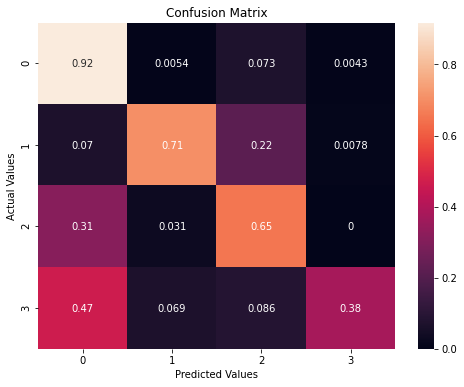

In [20]:
#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Output

In [21]:
X_test = pd.read_csv('X_test_processed.csv')
X_test = X_test.set_index('id')
X_test = X_test.drop(columns=drop_columns)

In [22]:
X_test

,std_ECG_P_Onsets,mean_ECG_P_Onsets,median_ECG_P_Onsets,max_ECG_P_Onsets,min_ECG_P_Onsets,range_ECG_P_Onsets,std_ECG_P_Onsets_amplitudes,mean_ECG_P_Onsets_amplitudes,median_ECG_P_Onsets_amplitudes,max_ECG_P_Onsets_amplitudes,...,mean_QRS_complexes,mean_RR_intervals,median_QRS_complexes,median_RR_intervals,min_QRS_complexes,min_RR_intervals,range_QRS_complexes,range_RR_intervals,std_QRS_complexes,std_RR_intervals
id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,0.098102,-0.036715,-0.002588,0.254078,...,65.296296,257.258065,64.0,252.0,34.0,237.0,88.0,55.0,21.183178,17.439236
1,1682.665791,2923.944444,2953.0,5670.0,184.0,5486.0,0.012136,-0.019629,-0.020340,0.003337,...,103.750000,322.058824,85.5,322.0,70.0,258.0,93.0,113.0,34.493659,20.746284
2,2380.353080,3983.793103,3971.0,8012.0,132.0,7880.0,0.186183,-0.062754,-0.042067,0.387782,...,45.758621,281.142857,39.0,293.5,25.0,120.0,74.0,393.0,19.404328,84.549949
3,2423.015742,4159.482759,4136.0,8210.0,75.0,8135.0,0.094438,-0.098866,-0.082155,0.069019,...,72.307692,289.500000,67.0,290.0,33.0,278.0,90.0,21.0,21.808201,5.267827
4,2371.572756,4180.206897,4277.0,8120.0,126.0,7994.0,0.023364,-0.012615,-0.006197,0.027511,...,58.214286,286.035714,51.5,299.0,39.0,147.0,74.0,172.0,18.750918,39.600218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3406,NaN,NaN,NaN,NaN,NaN,NaN,0.025966,-0.006726,-0.004288,0.112719,...,39.804878,206.400000,38.0,212.5,25.0,99.0,41.0,216.0,10.196172,39.713222
3407,NaN,NaN,NaN,NaN,NaN,NaN,0.091447,-0.042811,-0.030184,0.294462,...,43.133333,262.774194,42.0,294.0,26.0,93.0,65.0,239.0,10.088718,70.104397
3408,NaN,NaN,NaN,NaN,NaN,NaN,0.075401,-0.086413,-0.083060,0.110370,...,45.714286,227.840580,47.0,228.0,33.0,187.0,27.0,76.0,7.174533,17.218648


In [23]:
y_test = clf.predict(X_test)
y_test = [np.argmax(line) for line in y_test]

In [24]:
data_y_test = {
    'id': [i for i in range(len(y_test))],
    'y': y_test
}
df_y_test = pd.DataFrame(data_y_test)
df_y_test.to_csv('y_test.csv', index=False)

In [25]:
df_y_test

,id,y
0,0,0
1,1,2
2,2,3
3,3,0
4,4,2
...,...,...
3406,3406,2
3407,3407,0
3408,3408,0
3409,3409,0


# Parameter Tuning

In [26]:
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import StratifiedKFold

def objective(trial, X, y):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
#         "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
#         "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
#         "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
#         "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
#         "bagging_fraction": trial.suggest_float(
#             "bagging_fraction", 0.2, 0.9, step=0.1
#         ),
#         "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
#         "feature_fraction": trial.suggest_float(
#             "feature_fraction", 0.2, 0.9, step=0.1
#         ),
        
        "objective": "multiclass",
        "num_class": 4,
        "boosting_type": "gbdt",
        'num_leaves': trial.suggest_int('num_leaves', 5, 3000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = np.ravel(y.iloc[train_idx]), np.ravel(y.iloc[test_idx])
        
#         print(X_train, y_train)
#         print(X_test, y_test)

        model = lgbm.LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="multi_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "multi_logloss")
            ],  # Add a pruning callback
        )
        # predict the results
        y_pred = model.predict(X_test)
        cv_scores[idx] = f1_score(y_test, y_pred, average='micro')
    
    print("CV scores", cv_scores)

    return 1 - np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=100)

[I 2021-12-03 17:27:58,883] A new study created in memory with name: LGBM Classifier
/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.war

CV scores [0.58856346 0.58938547 0.58798883 0.58798883 0.58798883]


/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The repo

CV scores [0.58856346 0.58938547 0.58798883 0.58798883 0.58798883]


/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The repo

CV scores [0.58856346 0.58938547 0.58798883 0.58798883 0.58798883]


/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWar

CV scores [0.58856346 0.58938547 0.58798883 0.58798883 0.58798883]


/home/tvinh/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/tvinh/.local/lib/python3.8/site-packages/optuna/trial/_trial.py:590: UserWarning: The repo

CV scores [0.75313808 0.70949721 0.73882682 0.74022346 0.73324022]


In [ ]:
best_trial = study.best_trial

print(f"Value: {best_trial.value}")
print(f"Params: {best_trial.params}")

In [ ]:
# Run the best model

# build the lightgbm model
d_train=lgbm.Dataset(X_train, label=y_train)

#training the model
params = best_trial.params
params['objective'] = 'multiclass'
params['num_class'] = 4
clf=lgbm.train(params, d_train, 100)  #training the model on 100 epocs

In [ ]:
# predict the results
y_val_pred = clf.predict(X_val)
y_val_pred = [np.argmax(line) for line in y_val_pred]

# view accuracy
from sklearn.metrics import f1_score
accuracy = f1_score(y_val_pred, y_val, average='micro')
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy))

In [ ]:
lgbm.plot_importance(clf, figsize=(12,20))

In [ ]:
df_feature_importance = (
    pd.DataFrame({
        'feature': clf.feature_name(),
        'importance': clf.feature_importance(),
    })
    .sort_values('importance', ascending=False)
)
df_feature_importance

In [ ]:
cm_df = confusion_matrix(y_val, y_val_pred)
cm_df = normalize(cm_df, norm='l1')

#Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# Save model

In [ ]:
import pickle

# save
pickle.dump(clf, open("lgbm.pkl", "wb"))